In [1]:
%cd ~/Desktop/ActiveLearningCode/  
# Insert your path to the ActiveLearningCode folder

import scipy as sp
import numpy as np
from sklearn.datasets import make_moons
from util.Graph_manager import Graph_manager
import matplotlib.pyplot as plt
import scipy.linalg as sla
import copy
from util.al_util import *
from scipy.stats import norm
from scipy.optimize import  root


%load_ext autoreload

/Users/Kevin/Desktop/ActiveLearningCode


In [2]:
%autoreload

In [3]:
plt.style.use('ggplot')

## Helper Functions

Includes lots of functions for computing gaussian approximation to probit, with two different pdfs (normal and logistic).

In [4]:
################# Psi = cdf of Normal distribution ########################

def pdf_deriv(t, gamma):
    return -t*norm.pdf(t, scale = gamma)/(gamma**2)


def hess_calc(uj_, yj_, gamma):
    return -(pdf_deriv(uj_*yj_, gamma)*norm.cdf(uj_*yj_,scale=gamma)
                     - norm.pdf(uj_*yj_,scale=gamma)**2)/ (norm.cdf(uj_*yj_,scale=gamma)**2)

def Hess(u, y, labeled, Lt, gamma, debug=False):
    """
    Assuming matrices are sparse, since L_tau should be relatively sparse, 
        and we are perturbing with diagonal matrix.
    """
    H_d = np.zeros(u.shape[0])
    for j, yj in zip(labeled, y):
        H_d[j] = hess_calc(u[j], yj, gamma)
    if debug:
        print(H_d[np.nonzero(H_d)])
    if np.any(H_d == np.inf):
        print('smally')
    return Lt + sp.sparse.diags(H_d, format='csr')

def J(u, y, labeled, Lt, gamma, debug=False):
    vec = np.zeros(u.shape[0])
    for j, yj in zip(labeled,y):
        vec[j] = -yj*norm.pdf(u[j]*yj, gamma)/norm.cdf(u[j]*yj, gamma)
    if debug:
        print(vec[np.nonzero(vec)])
    return Lt @ u + vec

def probit_map_dr(Z_, yvals, gamma, Ct):
    """
    Probit MAP estimator, using dimensionality reduction via Representer Theorem.
    *** This uses cdf of normal distribution ***
    
    Deprecated?
    """
    Ctp = Ct[np.ix_(Z_,Z_)]
    J = len(yvals)
    #print(Ctp)
    def f(x):
        vec = [yj*norm.pdf(x[j]*yj, scale=gamma)/norm.cdf(x[j]*yj, scale=gamma) for j,yj in enumerate(yvals)]
        if np.any(vec == np.inf):
            print('smally in f')
        #print(sla.norm(x - Ctp @ vec))
        #print(vec)
        return x - Ctp @ vec
    
    def fprime(x):
        H = -Ctp * np.array([(pdf_deriv(x[j]*yj,gamma)*norm.cdf(x[j]*yj,scale=gamma)
                         - norm.pdf(x[j]*yj,scale=gamma)**2)/ (norm.cdf(x[j]*yj,scale=gamma)**2)
                            for j, yj in enumerate(yvals)])
        if np.any(H == np.inf):
            print('smally')
        H[np.diag_indices(J)] += 1.0
        return H
    
    x0 = np.random.rand(J)
    x0[np.array(yvals) < 0] *= -1
    res = root(f, x0, jac=fprime)
    print(np.allclose(0., f(res.x)))
    
    
    tmp = sla.inv(Ctp) @ res.x
    
    return Ct[:, Z_] @ tmp


In [5]:
###################### Psi = cdf of logistic #######################
def log_pdf(t, g):
    return np.exp(-t/g)/(g*(1. + np.exp(-t/g)))

def log_cdf(t, g):
    return 1.0/(1.0 + np.exp(-t/g))

def log_pdf_deriv(t, g):
    return -np.exp(-t/g)/((g*(1. + np.exp(-t/g)))**2.)


def hess_calc2(uj_, yj_, gamma):
    return -(log_pdf_deriv(uj_*yj_, gamma)*log_cdf(uj_*yj_, gamma)
                     - log_pdf(uj_*yj_, gamma)**2)/ (log_cdf(uj_*yj_, gamma)**2)

def Hess2(u, y, labeled, Lt, gamma, debug=False):
    """
    Assuming matrices are sparse, since L_tau should be relatively sparse, 
        and we are perturbing with diagonal matrix.
    """
    H_d = np.zeros(u.shape[0])
    for j, yj in zip(labeled, y):
        H_d[j] = hess_calc2(u[j], yj, gamma)
    if debug:
        print(H_d[np.nonzero(H_d)])
    if np.any(H_d == np.inf):
        print('smally')
    return Lt + sp.sparse.diags(H_d, format='csr')

def J2(u, y, labeled, Lt, gamma, debug=False):
    vec = np.zeros(u.shape[0])
    for j, yj in zip(labeled,y):
        vec[j] = -yj*log_pdf(u[j]*yj, gamma)/log_cdf(u[j]*yj, gamma)
    if debug:
        print(vec[np.nonzero(vec)])
    return Lt @ u + vec


def probit_map_dr2(Z_, yvals, gamma, Ct):
    """
    Probit MAP estimator, using dimensionality reduction via Representer Theorem.
    *** This uses logistic cdf ***
    """
    
    Ctp = Ct[np.ix_(Z_,Z_)]
    J = len(yvals)
    
    def log_pdf(t):
        return np.exp(-t/gamma)/(gamma*(1. + np.exp(-t/gamma)))
    
    def log_cdf(t):
        return 1.0/(1.0 + np.exp(-t/gamma))
    
    def log_pdf_deriv(t):
        return -np.exp(-t/gamma)/((gamma*(1. + np.exp(-t/gamma)))**2.)
    
    def f(x):
        vec = [yj*log_pdf(x[j]*yj)/log_cdf(x[j]*yj) for j,yj in enumerate(yvals)]
        return x - Ctp @ vec
    
    def fprime(x):
        H = -Ctp * np.array([(log_pdf_deriv(x[j]*yj)*log_cdf(x[j]*yj)
                         - log_pdf(x[j]*yj)**2)/ (log_cdf(x[j]*yj)**2) 
                             for j, yj in enumerate(yvals)])
        if np.any(H == np.inf):
            print('smally')
        H[np.diag_indices(J)] += 1.0
        return H
    
    x0 = np.random.rand(J)
    x0[np.array(yvals) < 0] *= -1
    res = root(f, x0, jac=fprime)
    
    
    tmp = sla.inv(Ctp) @ res.x
    
    return Ct[:, Z_] @ tmp

In [6]:
def get_acc(u, labels):
    u_ = np.sign(u)
    u_[u_ == 0] = 1
    corr = sum(1.*(u_ == labels))
    
    return corr, corr/u.shape[0]    

# Accuracy of Probit vs GR With EigenTruncation

Rechoosing to get both clusters
num incorrect = 0


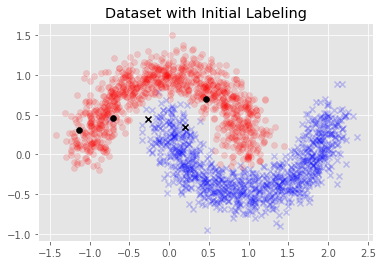

In [7]:
# Underlying dataset- hyperparameters
N = 2000

X, labels = make_moons(N, noise=0.15)
gm = Graph_manager()

n_start = 5
labeled_orig = list(np.random.choice(list(range(N)), size=n_start, replace=False))
while sum(labels[labeled_orig]) == n_start or sum(labels[labeled_orig]) == 0:
    print('Rechoosing to get both clusters')
    labeled_orig = list(np.random.choice(list(range(N)), size=n_start, replace=False))

labels[np.where(labels == 0)[0]] = -1.

ind_ord = list(np.where(labels == -1)[0]) + list(np.where(labels == 1)[0])

plot_iter(labels, X, labels, labeled_orig)

# Define the number of k-nearest neighbors
knn_ = 15

In [8]:
# Create similarity graph 
neig = 500
graph_params = {
    'knn'    : knn_,
    'sigma'  : 5.,
    'Ltype'  : 'normed',
    'n_eigs' : neig,
    'zp_k'   : None
}

print('Num eigenvalues used = %s' %(str(neig))) 
w, v = gm.from_features(X, graph_params, debug=True)



Num eigenvalues used = 500
Compute eigs from scratch


### Probit Using truncation $C_\tau$

True
True
True


/Users/Kevin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


True
True
True
True
True
True


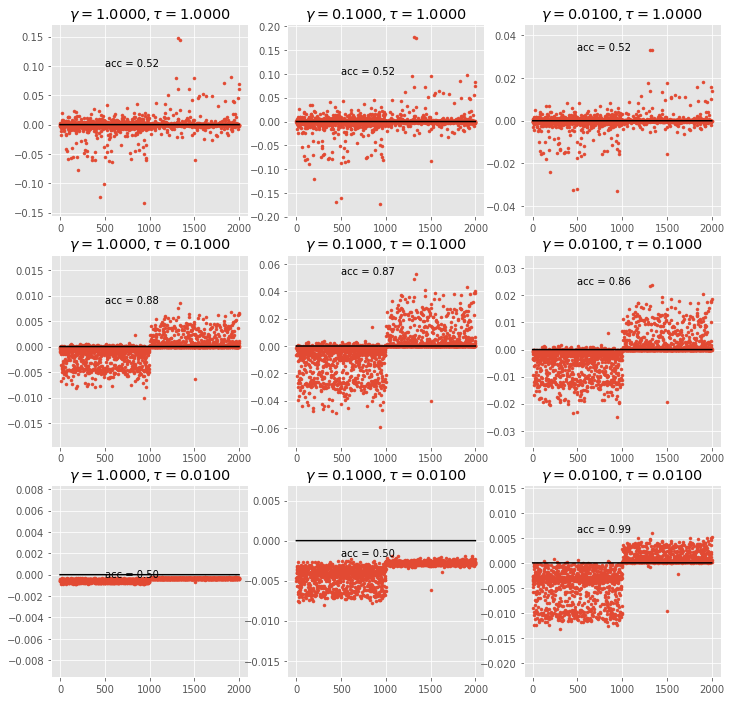

In [9]:
TAUS = [.1**i for i in range(3)]
GAMMAS = [.1**i for i in range(3)]

fig = plt.figure(figsize=(12,12))
i,j = 1,1
for tau in TAUS:
    # Calculate the prior covariance and precision matrix (i.e. graph Laplacian)
    d = (tau ** (2.)) * ((w + tau**2.) ** (-1.))
    Ct = v @ sp.sparse.diags(d, format='csr') @ v.T
    
    for gamma in GAMMAS: 

        # Find MAP estimator under normal probit posterior, using truncation C_tau
        u_map = probit_map_dr(labeled_orig, labels[labeled_orig], gamma, Ct)
        corr, acc = get_acc(u_map, labels)
        
        # Plot the result
        ax = fig.add_subplot(3,3,i)
        ax.scatter(range(N), u_map[ind_ord], marker='.')
        ax.plot(range(N), N*[0], 'k', linewidth=1.5)
        #plt.ylim(-1,1)
        plt.title(r'$\gamma =%1.4f, \tau=%1.4f$' % (gamma, tau))
        plt.annotate(r'acc = %0.2f' % acc, (500,min(0.1, max(u_map))))
        i += 1

    

plt.show()
    

### Gaussian Regression Using $C_{\tau}^{-1}$

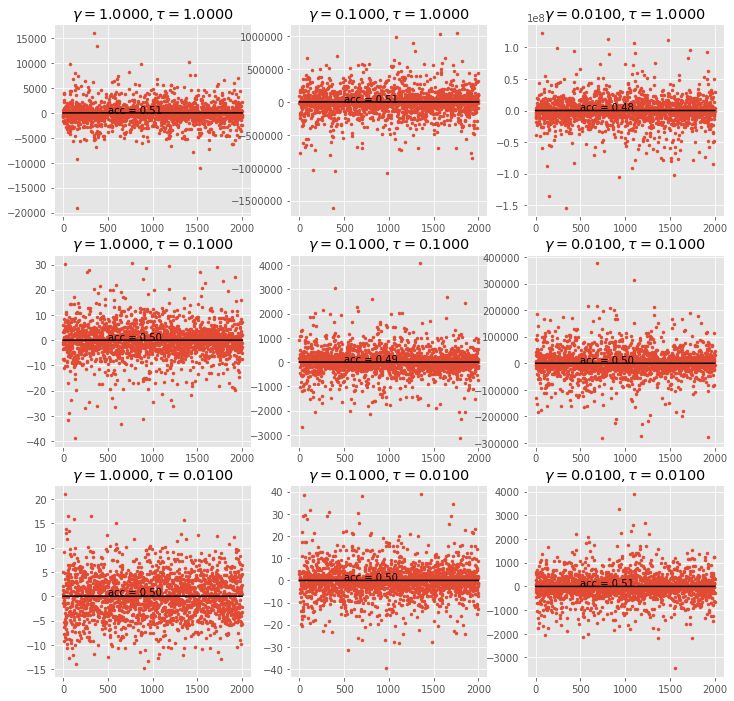

In [10]:
fig = plt.figure(figsize=(12,12))
i,j = 1,1

for tau in TAUS:
    # Calculate the prior covariance and precision matrix (i.e. graph Laplacian)
    d = (tau ** (2.)) * ((w + tau**2.) ** (-1.))
    Ct_inv = v @ sp.sparse.diags(1./d, format='csr') @ v.T  # this is L_tau
    
    for gamma in GAMMAS: 
        gamma2 = gamma**2.
        # Find MAP estimator of Gaussian Regression model (i.e. the mean of the posterior) -- WITH truncated L_tau (C_tau^{-1})
        C = get_init_post(Ct_inv, labeled_orig, gamma2)
        u_map = (C[:,labeled_orig].dot(labels[labeled_orig]))/gamma2
        
        # Plot the result
        corr, acc = get_acc(u_map, labels)
        ax = fig.add_subplot(3,3,i)
        ax.scatter(range(N), u_map[ind_ord], marker='.')
        ax.plot(range(N), N*[0], 'k', linewidth=1.5)
        #plt.ylim(-1,1)
        plt.title(r'$\gamma =%1.4f, \tau=%1.4f$' % (gamma, tau))
        plt.annotate(r'acc = %0.2f' % acc, (500,min(0.1, max(u_map))))
        i += 1

    

plt.show()
    

### Gaussian Regression Using "Full" $L_\tau$

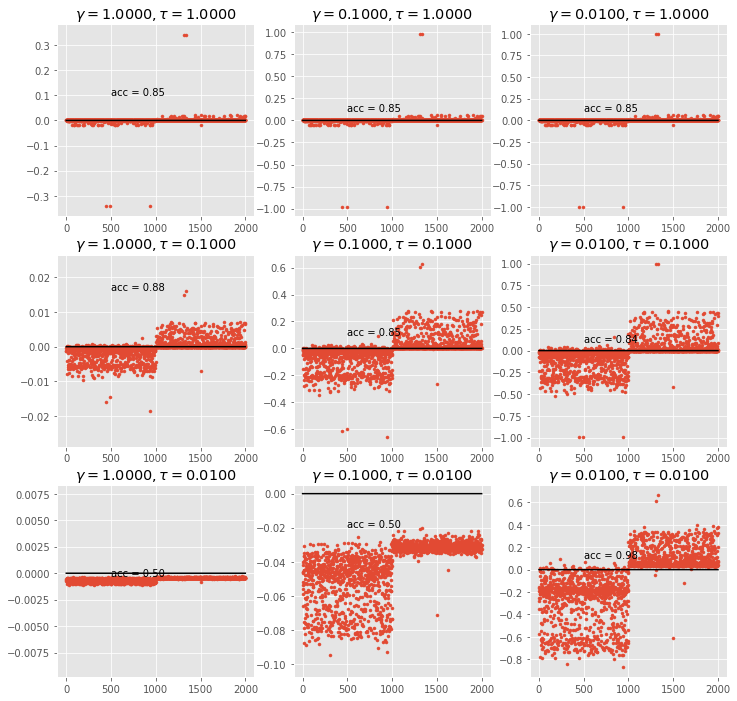

In [11]:
fig = plt.figure(figsize=(12,12))
i,j = 1,1

for tau in TAUS:
    # Calculate the precision matrix (i.e. graph Laplacian)
    Lt = (tau**-2.)*(gm.L + sp.sparse.diags(N*[tau**2.])).toarray()
    
    for gamma in GAMMAS: 
        gamma2 = gamma**2.
        # Find MAP estimator under Gaussian Regression (i.e. the mean) -- WITH FULL L_tau
        C = get_init_post(Lt, labeled_orig, gamma2)
        u_map = (C[:,labeled_orig].dot(labels[labeled_orig]))/gamma2
        
        # Plot the result
        corr, acc = get_acc(u_map, labels)
        ax = fig.add_subplot(3,3,i)
        ax.scatter(range(N), u_map[ind_ord], marker='.')
        ax.plot(range(N), N*[0], 'k', linewidth=1.5)
        #plt.ylim(-1,1)
        plt.title(r'$\gamma =%1.4f, \tau=%1.4f$' % (gamma, tau))
        plt.annotate(r'acc = %0.2f' % acc, (500,min(0.1, max(u_map))))
        i += 1

    

plt.show()
    

# Active Learning with Gaussian Approximation of Probit

### Gaussian Approximation of Probit Posterior

$$
\begin{align}
    p_p(\mathbf{u} | \mathbf{y}) &\propto \exp \left( -\frac{1}{2}\langle \mathbf{u}, L_\tau \mathbf{u}\rangle  + \sum_{j \in Z'} \log \Psi_\gamma(u_j y_j)\right) \\
        & \approx \mathcal{N}\left(\hat{\mathbf{u}}, H_p^{-1}(\hat{\mathbf{u}})  \right)
\end{align}
$$

where $\hat{\mathbf{u}}$ is the MAP estimator of the Probit posterior and $H_p(\hat{\mathbf{u}})$ is the Hessian of the Probit functional 

$$
J_p(\mathbf{u}) = \frac{1}{2}\langle \mathbf{u}, L_\tau \mathbf{u}\rangle  - \sum_{j \in Z'} \log \Psi_\gamma(u_j y_j)
$$
evaluated at the MAP estimate, $\hat{\mathbf{u}}$. 

num incorrect = 0


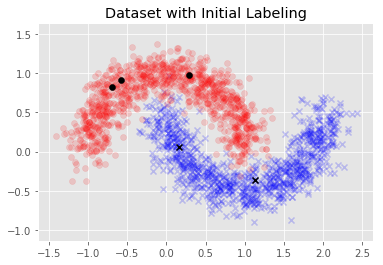

In [12]:
# Underlying dataset- hyperparameters
N = 2000

X, labels = make_moons(N, noise=0.15)
gm = Graph_manager()

n_start = 5
labeled_orig = list(np.random.choice(list(range(N)), size=n_start, replace=False))
while sum(labels[labeled_orig]) == n_start or sum(labels[labeled_orig]) == 0:
    print('Rechoosing to get both clusters')
    labeled_orig = list(np.random.choice(list(range(N)), size=n_start, replace=False))

labels[np.where(labels == 0)[0]] = -1.

ind_ord = list(np.where(labels == -1)[0]) + list(np.where(labels == 1)[0])

plot_iter(labels, X, labels, labeled_orig)

# Define the number of k-nearest neighbors
knn_ = 15

In [13]:
# Create similarity graph 
neig = 500
graph_params = {
    'knn'    : knn_,
    'sigma'  : 5.,
    'Ltype'  : 'normed',
    'n_eigs' : neig,
    'zp_k'   : None
}

print('Num eigenvalues used = %s' %(str(neig))) 
w, v = gm.from_features(X, graph_params, debug=True)



Num eigenvalues used = 500
Compute eigs from scratch


In [14]:
# Define hyperparameters tau, gamma
tau = 0.1
gamma = 0.1
gamma2 = gamma**2.

# Compute the prior covariance and related matrices
d = (tau ** (2.)) * ((w + tau**2.) ** (-1.))
Ct = v @ sp.sparse.diags(d, format='csr') @ v.T
Ct_inv = v @ sp.sparse.diags(1./d, format='csr') @ v.T  # spectral truncated version of L_tau
Lt = (tau ** (-2.)) * (gm.L + sp.sparse.diags(N*[tau**2.])) # "full" L_tau. CURRENTLY AS SPARSE MATRIX

## Active Learning with Spectral Truncation ($C_\tau^{-1}$)

Running for $4$ batches, each of size $5$, for a total of $20$ queries. After each batch, we recompute the Hessian of the -log posterior of probit, then invert.

In [15]:
# Obtain MAP estimator and Hessian at u_map
u_map = probit_map_dr2(labeled_orig, labels[labeled_orig], gamma, Ct)
H = Hess2(u_map, labels[labeled_orig], labeled_orig, Ct_inv, gamma)
C_orig = sp.linalg.inv(H)

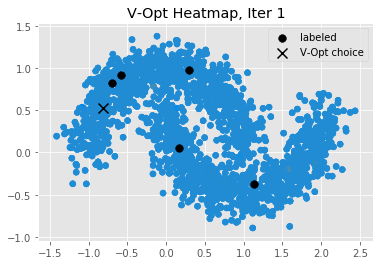

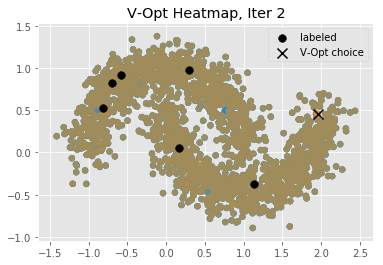

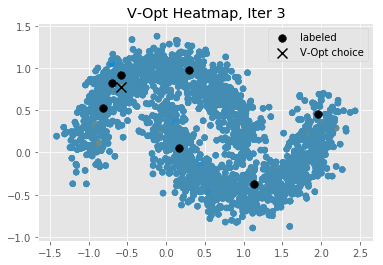

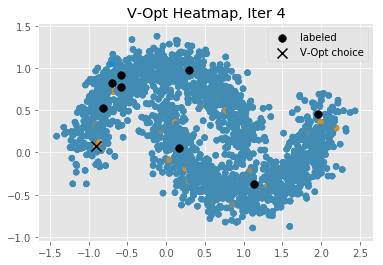

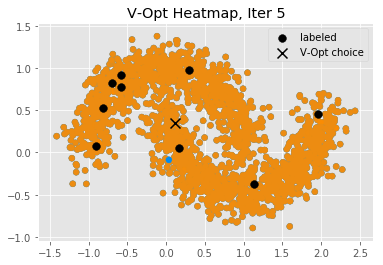

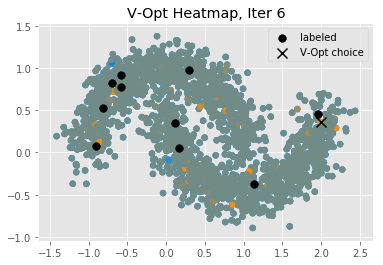

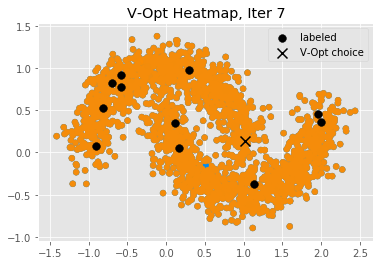

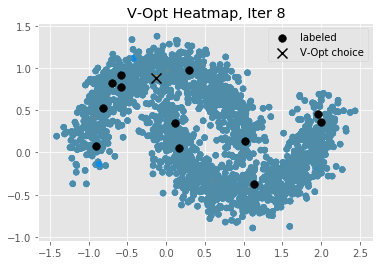

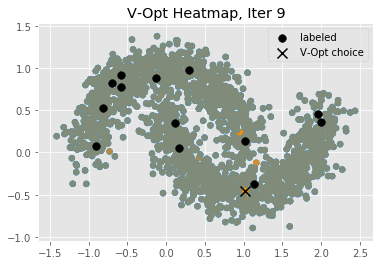

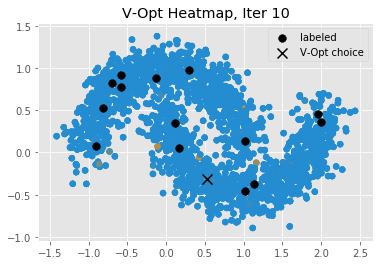

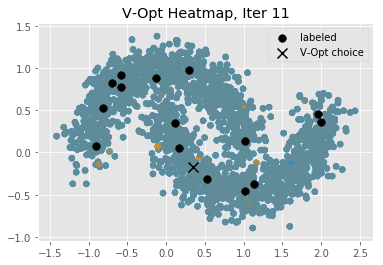

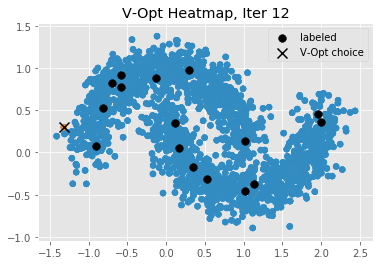

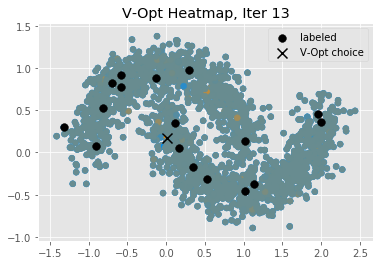

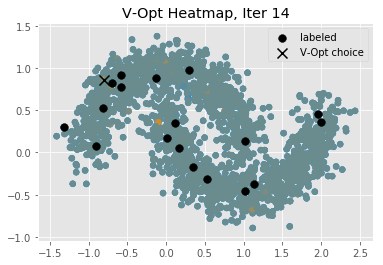

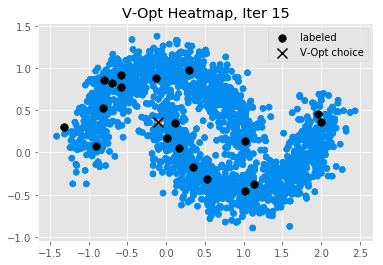

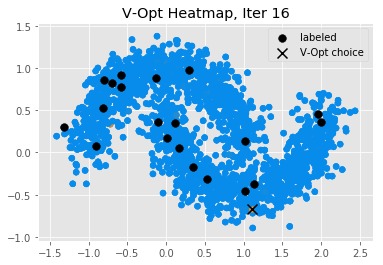

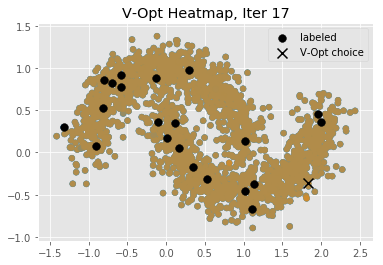

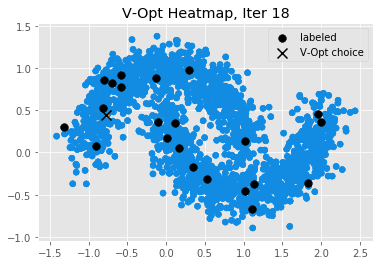

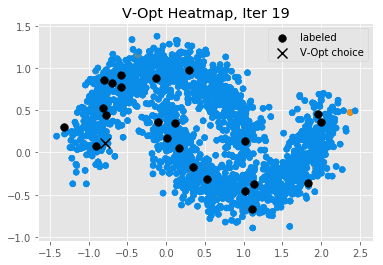

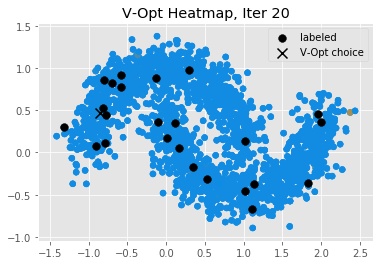

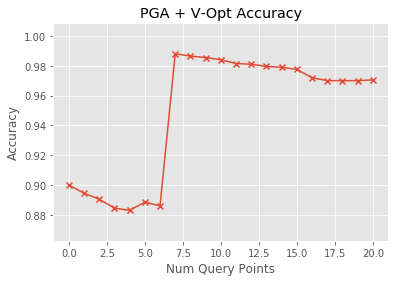

In [16]:
# Run V-Opt Active Learning
num_to_query = 20
batch_size = 5
num_batches = num_to_query // batch_size

C = copy.deepcopy(C_orig)    # get the original data, before AL choices
labeled = copy.deepcopy(labeled_orig)


# get the original accuracy
m = copy.deepcopy(u_map)
v_acc = []
v_acc.append(get_acc(m, labels)[1])


for i in range(num_to_query):
    # Calculate V-Opt criterion for unlabeled points
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    k, vopt = V_opt_record(C, unlabeled, gamma2)
    
    # Plot the V-Opt heatmap
    vopt = (vopt - min(vopt))/(max(vopt) - min(vopt))
    colors = [(x, 0.55,0.95*(1-x)) for x in vopt]
    plt.scatter(X[:,0], X[:,1], c=[(0,0.55,0.95) for _ in range(N)])
    plt.scatter(X[unlabeled, 0],X[unlabeled,1], c=colors)
    plt.scatter(X[labeled,0], X[labeled,1], c='k', marker='o', s=60, label=r'labeled')
    plt.scatter(X[k,0], X[k,1], c='k', marker='x', s=100, label='V-Opt choice')
    plt.title('V-Opt Heatmap, Iter %d' % (i+1))
    plt.legend()
    plt.show()
    
    
    
    # update labeled
    labeled += [k]
    
    
    m = probit_map_dr2(labeled, labels[labeled], gamma, Ct)
     
    if i % batch_size == 0 and i != 0:
        # update the posterior with the new MAP estimator, ASSUMING YOU HAVE THE CORRECT LABELS 
        H = Hess2(m, labels[labeled], labeled, Ct_inv, gamma)
        C = sp.linalg.inv(H)  
        
    else:
        # update posterior according to Gaussian updates (not currently accounting for new MAP estimator)
        ck = C[k,:]
        ckk = ck[k]
        C -= (1./(gamma2 + ckk)) * np.outer(ck,ck)

    
    # Record resulting accuracy
    v_acc.append(get_acc(m, labels)[1])

    
# Plot the accuracy of queries
plt.scatter(range(num_to_query + 1), v_acc, marker='x')
plt.plot(range(num_to_query + 1), v_acc)
plt.title(r'PGA + V-Opt Accuracy')
plt.xlabel(r'Num Query Points')
plt.ylabel(r'Accuracy')
#plt.ylim(0,1)
plt.show()

Note these runs of V-Opt are **not** necessarily deterministic, as it seems that the V-Opt landscape doesn't look so informative. In the "full" version however, they are deterministic.

## Active Learning with "Full" ($L_\tau$)

Running for $4$ batches, each of size $5$, for a total of $20$ queries. After each batch, we recompute the Hessian of the -log posterior of probit, then invert.

In [17]:
# Obtain MAP estimator and Hessian at u_map

u_map = probit_map_dr2(labeled_orig, labels[labeled_orig], gamma, Ct)
H = Hess2(u_map, labels[labeled_orig], labeled_orig, Lt, gamma)
Hd = H.toarray()
C_orig = sp.linalg.inv(Hd) # Costly usually I would think!

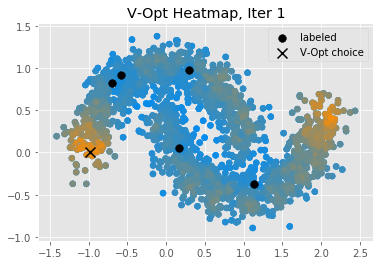

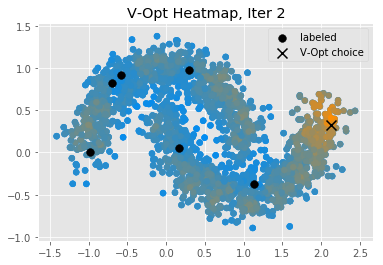

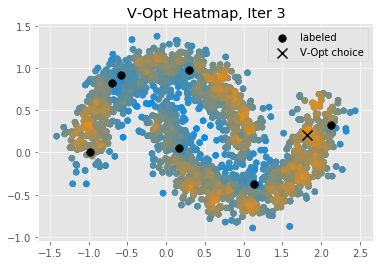

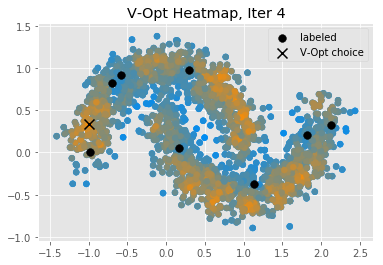

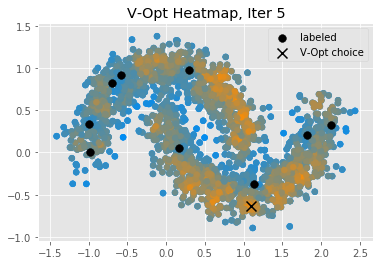

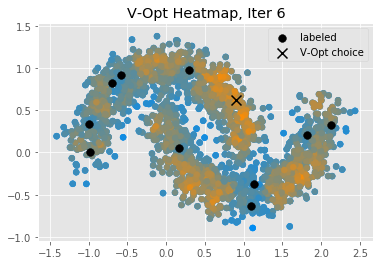

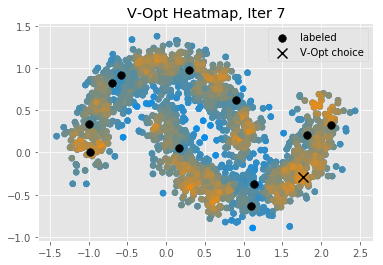

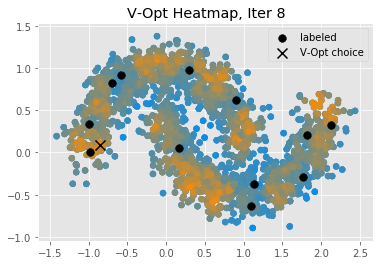

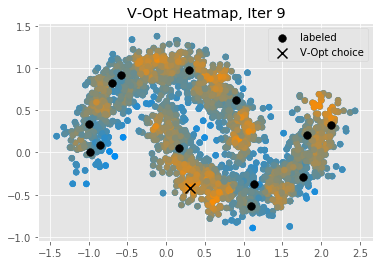

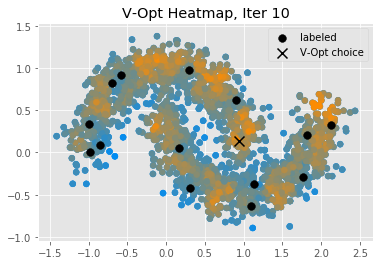

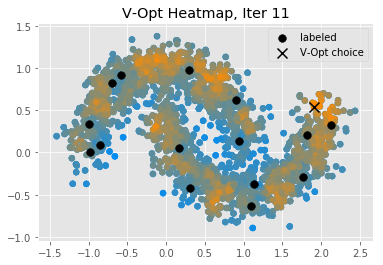

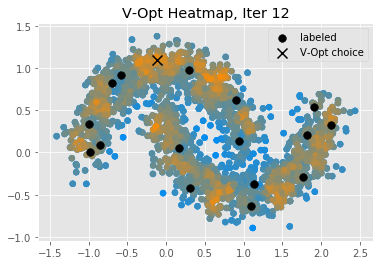

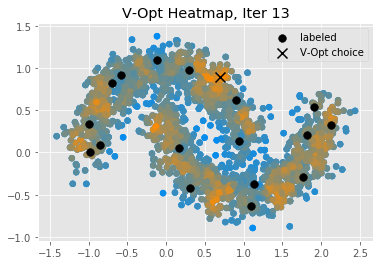

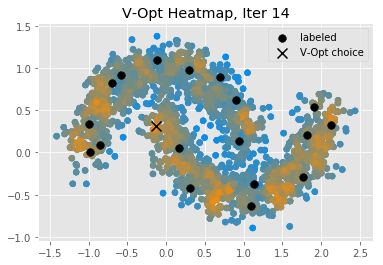

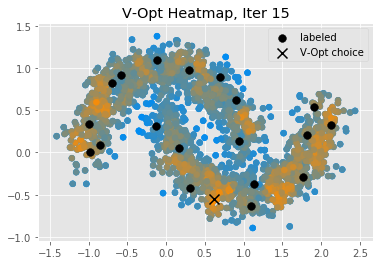

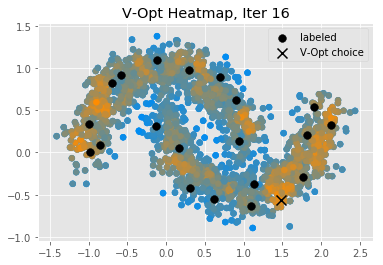

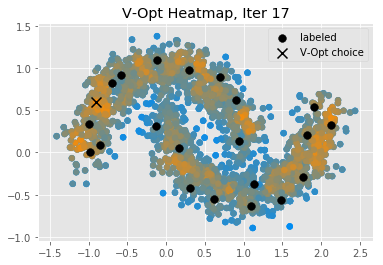

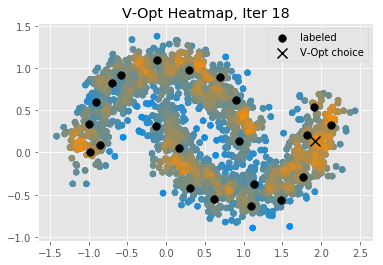

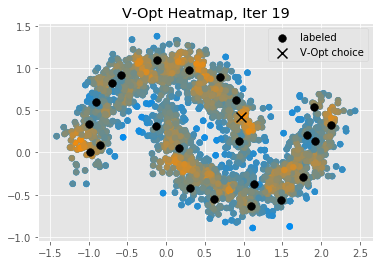

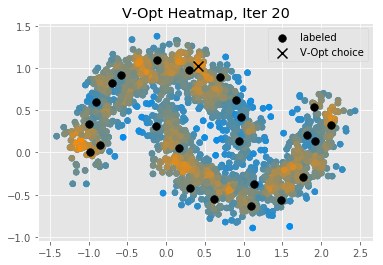

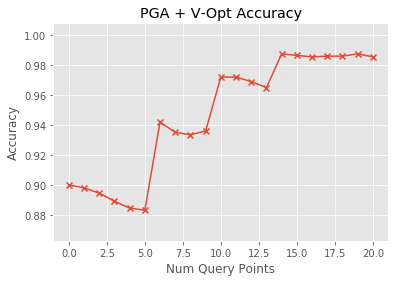

In [18]:
# Run V-Opt Active Learning
num_to_query = 20
batch_size = 5
num_batches = num_to_query // batch_size

C = copy.deepcopy(C_orig)    # get the original data, before AL choices
labeled = copy.deepcopy(labeled_orig)


# get the original accuracy
m = copy.deepcopy(u_map)
v_acc = []
v_acc.append(get_acc(m, labels)[1])


for i in range(num_to_query):
    # Calculate V-Opt criterion for unlabeled points
    unlabeled = list(filter(lambda x: x not in labeled, range(N)))
    k, vopt = V_opt_record(C, unlabeled, gamma2)
    
    # Plot the V-Opt heatmap
    vopt = (vopt - min(vopt))/(max(vopt) - min(vopt))
    colors = [(x, 0.55,0.95*(1-x)) for x in vopt]
    plt.scatter(X[:,0], X[:,1], c=[(0,0.55,0.95) for _ in range(N)])
    plt.scatter(X[unlabeled, 0],X[unlabeled,1], c=colors)
    plt.scatter(X[labeled,0], X[labeled,1], c='k', marker='o', s=60, label=r'labeled')
    plt.scatter(X[k,0], X[k,1], c='k', marker='x', s=100, label='V-Opt choice')
    plt.title('V-Opt Heatmap, Iter %d' % (i+1))
    plt.legend()
    plt.show()
    
    
    
    # update labeled
    labeled += [k]
    
    
    m = probit_map_dr2(labeled, labels[labeled], gamma, Ct)
     
    if i % batch_size == 0 and i != 0:
        # update the posterior with the new MAP estimator, ASSUMING YOU HAVE THE CORRECT LABELS 
        H = Hess2(m, labels[labeled], labeled, Lt, gamma).toarray()
        C = sp.linalg.inv(H)  
        
    else:
        # update posterior according to Gaussian updates (not currently accounting for new MAP estimator)
        ck = C[k,:]
        ckk = ck[k]
        C -= (1./(gamma2 + ckk)) * np.outer(ck,ck)

    
    # Record resulting accuracy
    v_acc.append(get_acc(m, labels)[1])

    
# Plot the accuracy of queries
plt.scatter(range(num_to_query + 1), v_acc, marker='x')
plt.plot(range(num_to_query + 1), v_acc)
plt.title(r'PGA + V-Opt Accuracy')
plt.xlabel(r'Num Query Points')
plt.ylabel(r'Accuracy')
#plt.ylim(0,1)
plt.show()